# Read data from Datalake

In [1]:
from spec.utils.s3 import S3

s3 = S3(bucket_name="vf-prd-scct-s3-landing")

In [ ]:
mbom_folder = "bom_structure/mbom_structure/da_batchdate=2025-06-12/rule_revision=VINFAST_WORKING_RULE/"

mbom = s3.get_concat_df_from_folder(mbom_folder)

mbom.head()

In [ ]:
ebom_folder = "bom_structure/ebom_structure/da_batchdate=2025-06-12/rule_revision=VINFAST_RELEASE_RULE/"

ebom = s3.get_concat_df_from_folder(ebom_folder)

ebom.head()

In [ ]:
print(ebom.columns.tolist())

# Test API

In [2]:
"""
End-to-end test flow cho spec.api.server
---------------------------------------
1.  Tạo session        (POST /sessions)
2.  Stream message     (POST /chat/stream)
3.  Lấy lại session    (GET  /sessions/{id})
4.  Health-check       (GET  /healthz)
"""

import pyarrow as pa
import asyncio, json
from uuid import uuid4
import base64
import io
import pickle
import pandas as pd
from PIL import Image

import httpx

BASE_URL = "http://localhost:9000"


# ─── 1. Tạo session ────────────────────────────────────────────
async def create_session(client: httpx.AsyncClient) -> str:
    payload = {"username": f"tester-{uuid4().hex[:6]}"}
    r = await client.post("/sessions", json=payload)
    r.raise_for_status()
    sid: str = r.json()["session_id"]
    print(f"✅  Created session: {sid}")
    return sid


# ─── 2. Chat streaming (NDJSON) ────────────────────────────────
async def stream_chat(
    client: httpx.AsyncClient, session_id: str, text: str
) -> str:
    """
    Gửi tin nhắn và đọc NDJSON stream từ /chat/stream.
    Mỗi dòng JSON có trường ``kind``:
        {"kind":"text","data":"<chunk>"}\n
        {"kind":"end_stream","status":"ok"}\n
        {"kind":"image/png","b64":"<base64>"}\n
        {"kind":"dataframe_arrow","b64":"<base64>"}\n
        {"kind":"pickle","b64":"<base64>"}\n
    """
    url  = "/chat/stream"
    body = {"session_id": session_id, "message": text}
    collected: list[str] = []

    async with client.stream("POST", url, json=body, timeout=None) as r:
        r.raise_for_status()

        async for line in r.aiter_lines():
            if not line.strip():
                continue

            try:
                obj: dict = json.loads(line)
            except json.JSONDecodeError:
                print("cannot parse:", line)
                continue

            kind = obj.get("kind")
            if kind == "text":
                chunk: str = obj["data"]
                print(chunk, end="", flush=True)
                collected.append(chunk)
            elif kind == "dataframe_arrow":
                buf = base64.b64decode(obj["b64"])
                df  = pa.ipc.deserialize_pandas(buf)
                print(df)
            elif kind == "image/png":
                img = Image.open(io.BytesIO(base64.b64decode(obj["b64"])))
                img.show()
            elif kind == "pickle":
                obj = pickle.loads(base64.b64decode(obj["b64"]))
                break          # kết thúc stream

    print("\n— stream complete —")
    return "".join(collected)


# ─── 3. Truy xuất lại session ─────────────────────────────────
async def get_session(client: httpx.AsyncClient, session_id: str) -> None:
    r = await client.get(f"/sessions/{session_id}")
    r.raise_for_status()
    data = r.json()
    print("🗄️  Session history (n =", len(data["messages"]), ")")
    for m in data["messages"]:
        print(m["role"].ljust(9), ":", m["content"])


# ─── 4. Health-check ──────────────────────────────────────────
async def health_check(client: httpx.AsyncClient) -> None:
    r = await client.get("/healthz")
    r.raise_for_status()
    print("❤️  Healthcheck:", r.json())


# ─── Main demo ────────────────────────────────────────────────
async def main():
    async with httpx.AsyncClient(base_url=BASE_URL, timeout=None) as client:
        sid = await create_session(client)

        await stream_chat(client, sid, "Show me all records of BOM data. Just show me")        

await main()

✅  Created session: 003f9e4f-c0f9-4e90-bacc-154c5aec41f7


               part_id car_model                                       file  \
0          S02E9900023      None      VFE_Shop/20250417/20250417_611714.txt   
1          S02E9900023      None      VFE_Shop/20250417/20250417_611714.txt   
2          S02E9900023      None      VFE_Shop/20250417/20250417_611714.txt   
3          S02E9900023      None      VFE_Shop/20250417/20250417_611714.txt   
4          S02E9900023      None      VFE_Shop/20250417/20250417_611714.txt   
...                ...       ...                                        ...   
417876  BEX80111213ORB       VF9  VF9/Assembly/20250417/20250417_771374.txt   
417877  BEX80111213GNB       VF9  VF9/Assembly/20250417/20250417_771374.txt   
417878  BEX80111213BKA       VF9  VF9/Assembly/20250417/20250417_771374.txt   
417879  BEX80111122GNB       VF9  VF9/Assembly/20250417/20250417_771374.txt   
417880  BEX80111118GNB       VF9  VF9/Assembly/20250417/20250417_771374.txt   

        bom_line_number  group_id group_revision_st

# Test Spec modules

In [1]:
import asyncio
import time
from spec.config import async_client

2025-06-05 22:13:52.295 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [2]:


# Number of async jobs
NUM_JOBS = 2000

async def run_job(idx):
    # Measure start time for this job
    start = time.perf_counter()
    response = await async_client.responses.create(
        model="gpt-4.1-nano",
        input=f"Write a one-sentence bedtime story about a unicorn."
    )
    elapsed = time.perf_counter() - start
    print(f"Job {idx} finished in {elapsed:.2f} seconds. Output: {response.output_text}")
    return elapsed

async def main():
    # Measure total time
    total_start = time.perf_counter()
    # Create all jobs
    tasks = [run_job(i) for i in range(NUM_JOBS)]
    # Run all jobs concurrently
    results = await asyncio.gather(*tasks)
    total_elapsed = time.perf_counter() - total_start
    print(f"\nAll {NUM_JOBS} jobs finished.")
    print(f"Total elapsed time: {total_elapsed:.2f} seconds")
    print(f"Average job time: {sum(results)/len(results):.2f} seconds")

await main()

APITimeoutError: Request timed out.

Job 1007 finished in 1848.45 seconds. Output: Once upon a twilight, the gentle unicorn oved quietly through a shimmering forest, leaving trails of stardust to lull the world into peaceful dreams.
Job 1194 finished in 1848.94 seconds. Output: Once upon a time, a gentle unicorn named Luna spread her shimmering wings and gently soared across the starry sky, whispering sweet dreams to all the sleeping creatures below.
Job 1151 finished in 1848.94 seconds. Output: In a quiet meadow under a starry sky, the gentle unicorn drifted to sleep, dreaming of magical adventures yet to come.
Job 1082 finished in 1848.96 seconds. Output: In a quiet, moonlit forest, a gentle unicorn named Luna spread her shimmering wings and softly whispered goodnight to all the dreams she watched over.
Job 1263 finished in 1848.92 seconds. Output: Once upon a time, a gentle unicorn named Luna hopped over the moonlit meadows, bringing sweet dreams to everyone who saw her shimmering mane.
Job 1251 finished in 1848.93 sec

In [14]:
resp = await async_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role":"user","content":"One-sentence bedtime story about a unicorn"}]
)

In [17]:
print(resp.response_ms)

AttributeError: 'ChatCompletion' object has no attribute 'response_ms'

In [15]:
import json

res = json.loads(resp.model_dump_json())
print(res)

{'id': 'chatcmpl-Bf6VxvTrlssnL3mmUC3GxB3N2T8aa', 'choices': [{'finish_reason': 'stop', 'index': 0, 'logprobs': None, 'message': {'content': 'As the shimmering stars twinkled above, Luna the unicorn spread her ethereal wings and soared through the moonlit sky, granting sweet dreams to every child lying in slumber below.', 'refusal': None, 'role': 'assistant', 'annotations': [], 'audio': None, 'function_call': None, 'tool_calls': None}, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'detected': False, 'filtered': False}, 'protected_material_text': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'created': 1749136189, 'model': 'gpt-4o-mini-2024-07-18', 'object': 'chat.completion', 'service_tier': None, 'system_fingerprint': 'fp_7a53abb7a2', 'usage': {'completion_tokens': 38, 'prompt

In [16]:
print(res.keys())

dict_keys(['id', 'choices', 'created', 'model', 'object', 'service_tier', 'system_fingerprint', 'usage', 'prompt_filter_results'])


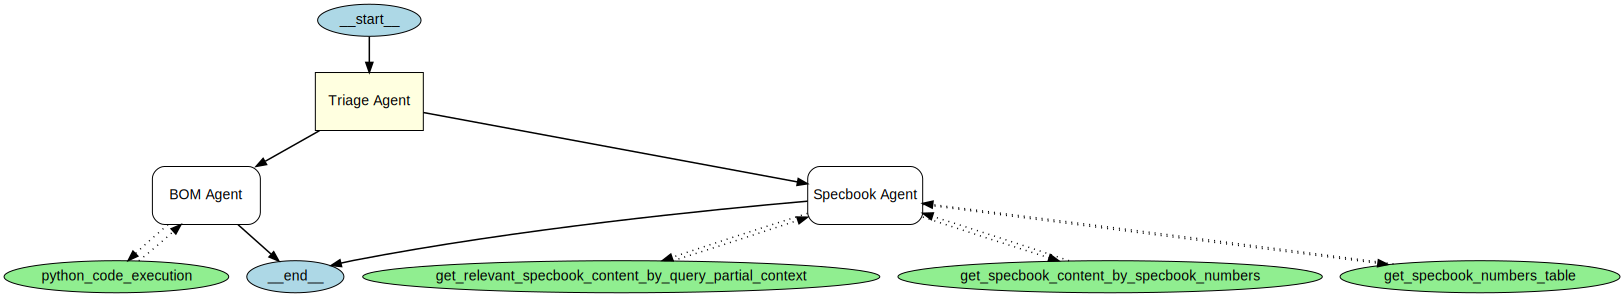

In [53]:
from agents.extensions.visualization import draw_graph

from spec.agents import triage_agent

draw_graph(triage_agent)

In [50]:
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from openai import AzureOpenAI
from dotenv import load_dotenv

load_dotenv()

token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default"
)

client = AzureOpenAI(
    azure_ad_token_provider=token_provider,
    azure_endpoint="https://aoai-eastus2-0001.openai.azure.com/",
    api_version="2025-03-01-preview",
)

import tiktoken

def num_tokens_from_text(string: str, encoding_name: str = "o200k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

WORDS = (
    "lorem ipsum dolor sit amet consectetur adipiscing elit sed do eiusmod "
    "tempor incididunt ut labore et dolore magna aliqua ut enim ad minim "
    "veniam quis nostrud exercitation ullamco laboris nisi ut aliquip ex "
    "ea commodo consequat duis aute irure dolor in reprehenderit in "
    "voluptate velit esse cillum dolore eu fugiat nulla pariatur in"
)

# corpus = WORDS * 4200 # 252000 tokens --> OK
corpus = WORDS * 13000 # 264000 tokens --> LIMIT TOKEN

print(num_tokens_from_text(corpus))


780000


In [52]:
import asyncio

from openai.types.responses import ResponseTextDeltaEvent

from agents import Agent, Runner

from agents import (set_default_openai_api, set_default_openai_client,
                    set_tracing_disabled)

set_default_openai_api("chat_completions")
set_default_openai_client(client)
set_tracing_disabled(disabled=True)


async def main():
    agent = Agent(
        name="Joker",
        instructions="You are a helpful assistant.",
        model="gpt-4.1-nano",
    )

    result = Runner.run_streamed(agent, input="Translate to English: " + corpus)
    async for event in result.stream_events():
        if event.type == "raw_response_event" and isinstance(event.data, ResponseTextDeltaEvent):
            print(event.data.delta, end="", flush=True)


await main()

TypeError: object Stream can't be used in 'await' expression

In [48]:
response = client.chat.completions.create(
    model="gpt-4.1-nano",
    messages=[
        {
            "role": "user",
            "content": "Translate to English: " + corpus
        }
    ]
)

print(response)

ChatCompletion(id='chatcmpl-Belr82EPHoHJGwKrduN8YkUl3jEpF', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The provided text is a long repetition of the classic placeholder text "Lorem Ipsum," which is nonsensical and used for design and formatting purposes. It does not have a meaningful translation as it is made up of Latin-like words intended to mimic real text without conveying actual content. \n\nIf you need a summary or specific parts translated, please specify.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], create

# Test async call OpenAI API

In [1]:
from settings.llm import *
import asyncio
from tool import *
from cache import cache

In [2]:
specbooks = cache["specbooks"]
specbook_numbers = list(cache["specbooks"].keys())
query = "Extract all the information about the Chassis group and anything related to it"


In [30]:
no, parsed = await _process_one("VFDSXVCHS0534")
print(parsed.is_relevant)
print(parsed.relevance_content)


True
**Front Upper and Lower Ball Joint Assemblies** (located on Page 7): 

1. **Front Upper Ball Joint Assembly LH**  
   - **Part No.**: CHS30002103  
   - **Material Requirement**: Specified as Ref 3.4  
   - **Applicability**: VN for VF35 ECO and VFe35 Plus models, ALL MARKETS for VFe35 ECO, VFe35 PLUS, and VFe35 PREMIUM models.
   - **Weight**: 1.1 Kg (Housing: 0.755 Kg; Ball Stud: 0.323 Kg)  
   - **Design Requirements**: Must be made of material specified and meet the functional/performance requirements.  

2. **Front Upper Ball Joint Assembly RH**  
   - **Part No.**: CHS30002110  
   - Same requirements as the LH version.  

3. **Front Lower Ball Joint Assembly LH**  
   - **Part No.**: CHS30002102  
   - Same requirements as for the Upper Ball Joint assemblies.  

4. **Front Lower Ball Joint Assembly RH**  
   - **Part No.**: CHS30002108  
   - Same requirements as for the other assemblies.  

These parts are mentioned under **Section 3.2** Technical Requirements in the speci

# Convert specbook md to xml format

In [2]:
import os
import re
from pathlib import Path

# Template for the XML output
FILE_TMPL = """
<filename>{name}</filename>
<pages>
{pages}
</pages>
"""

PAGE_TMPL = """
<page number="{num}">
{content}
</page>"""

def clean_toc_dots(text: str) -> str:
    """
    Remove lines or segments with long sequences of dots (e.g. '.............') 
    which are typically used in table of contents.
    """
    # Remove lines that are mostly dots or have a long sequence of dots
    # Remove any sequence of 6 or more consecutive dots
    cleaned_lines = []
    for line in text.splitlines():
        # Remove lines that are only dots or mostly dots
        if re.fullmatch(r'\s*\.{4,}\s*', line):
            continue
        # Remove long dot sequences within a line
        line = re.sub(r'\.{4,}', '', line)
        cleaned_lines.append(line)
    return "\n".join(cleaned_lines)

def parse_pages(text):
    """
    Parse the text into pages based on 'Page [number]' markers.
    Also remove long dot sequences from each page's content.
    """
    pattern = r'Page\s+(\d+)'
    matches = list(re.finditer(pattern, text))
    pages = []
    for i, match in enumerate(matches):
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
        num = match.group(1)
        # Extract content for this page
        content = text[start:end].strip()
        # Clean out table of contents dot lines/sequences
        content = clean_toc_dots(content)
        pages.append((num, content))
    return pages

def process_file(path: Path, out_dir: Path):
    """
    Process a single file: parse pages, clean dot lines, and write XML output.
    """
    with open(path, 'r', encoding='utf-8') as f:
        txt = f.read()
    pages = parse_pages(txt)
    pages_xml = "\n".join([PAGE_TMPL.format(num=num, content=content) for num, content in pages])
    content = FILE_TMPL.format(name=path.stem, pages=pages_xml)
    
    # Create the output directory if it does not exist, then save the file
    # dst = out_dir / f"{path.stem}.txt"
    # with open(dst, "w", encoding="utf-8") as f:
    #     f.write(content)
    return content

def process_folder(folder: Path, out_dir: Path):
    """
    Process all .txt files in a folder, converting them to cleaned XML format.
    """
    xml_files = []
    for fpath in folder.iterdir():
        if fpath.suffix == ".txt":
            xml = process_file(fpath, out_dir)
            xml_files.append(xml)
    return xml_files

# Example usage
folder_path = Path('/home/ubuntu/environment/aiopt/spec/data/specbook/specbook_md_rewrite')
out_dir = Path('/home/ubuntu/environment/aiopt/spec/data/specbook//specbook_md_xml')
out_dir.mkdir(parents=True, exist_ok=True)

files = folder_path.glob('*.txt')
print(len(list(files)))

xmls = process_folder(folder_path, out_dir)


653


In [6]:
from spec.utils.utils import num_tokens_from_text

In [7]:
all_content = "\n".join(xmls)
print(num_tokens_from_text(all_content))

7178422


# Test Translate

In [ ]:
import asyncio

from agents import Agent, ItemHelpers, Runner, trace
from settings.llm import *

"""
This example shows the parallelization pattern. We run the agent three times in parallel, and pick
the best result.
"""

english_agent = Agent(
    name="english_agent",
    instructions="You translate the user's message to english",
)

english_picker = Agent(
    name="english_picker",
    instructions="You pick the best english translation from the given options.",
)


async def main():
    
    msg = input("Hi! Enter a message, and we'll translate it to english.\n\n")

    res_1, res_2, res_3 = await asyncio.gather(
        Runner.run(
            english_agent,
            msg,
        ),
        Runner.run(
            english_agent,
            msg,
        ),
        Runner.run(
            english_agent,
            msg,
        ),
    )

    outputs = [
        ItemHelpers.text_message_outputs(res_1.new_items),
        ItemHelpers.text_message_outputs(res_2.new_items),
        ItemHelpers.text_message_outputs(res_3.new_items),
    ]

    translations = "\n\n".join(outputs)
    # print(f"\n\nTranslations:\n\n{translations}")

    best_translation = await Runner.run(
        english_picker,
        f"Input: {msg}\n\nTranslations:\n{translations}",
    )

    print("\n\n-----")

    print(f"Best translation: {best_translation.final_output}")


if __name__ == "__main__":
    asyncio.run(main())

# Extract part information from MBOM, Assy, Subcontract

In [2]:
import pandas as pd
from io import StringIO
from spec.utils.s3 import S3
from spec.utils.llm import completion_with_backoff, LLM
from spec.utils.utils import *

s3 = S3()


In [8]:
import pandas as pd
from io import StringIO
from pathlib import Path

def preprocess(path):
    raw = s3._get(path).decode("utf-8")
    lines = [line for line in raw.splitlines() if not line.startswith("#")]
    if lines and lines[0].startswith("bl"):
        lines[0] = lines[0].replace(",", "|")
    return pd.read_csv(StringIO("\n".join(lines)), delimiter="|", dtype=str)

# Load files

models = ["VF3", "VF5", "VF6", "VF7", "VF8", "VF9", "VFe34"]
folder = ["Assembly", "MBOM", "Subcontract", "EBOM"]
date = "20250603"

dfs = []


for m in models:
    for f in folder:    
        file_paths = s3.list_files(f"{m}/{f}/{date}")
        for file_path in file_paths:
            print(file_path)
            temp_df = preprocess(file_path)
            temp_df['model'] = m
            # temp_df = temp_df[:50]
            # temp_df.to_csv(f"{m}_{f}_{date}.csv", index=False)
            dfs.append(temp_df)
            break
    break

df = pd.concat(dfs, ignore_index=True)


VF3/Assembly/20250603/20250603_731654.txt
VF3/MBOM/20250603/20250603_732562.txt
VF3/Subcontract/20250603/20250603_735130.txt
VF3/EBOM/20250603/20250603_ASU69000001AA.txt


In [ ]:
# Keep relevant columns
keep = [
    'bl_item_item_id',
    'bl_item_object_name',
    'bl_item_vf4_itm_supplier_name',
    'VL5_module_group',
    'VL5_main_module',
    'VL5_module_name',
    'VL5_torque_inf',
    'model'
]
df = df[keep]

# Clean string columns
for col in df.select_dtypes(include='object'):
    df[col] = df[col].str.strip().str.upper()

df.drop_duplicates(inplace=True)

# Rename and filter
df = df.rename(columns={
    'bl_item_item_id': 'part_id',
    'bl_item_object_name': 'part_name',
    'bl_item_vf4_itm_supplier_name': 'supplier_name',
    'VL5_module_group': 'module_group',
    'VL5_main_module': 'main_module',
    'VL5_module_name': 'module_name',
    'VL5_torque_inf': 'torque_inf'
})
df = df[df['part_id'].str.len() > 10]

# Save if needed
df.to_parquet('data/PLM/mbom_assy_sub_parts_all_models.parquet')

df

In [ ]:
vs = VectorStore("PDF_search/vector_store/vinfast_part.pkl", s3, 1536, llm)

In [ ]:
chunks = vs.list_chunks()
part_ids = [c['chunk']['metadata']['Part ID'] for c in chunks]
print(len(chunks))
print(len(part_ids))

In [ ]:
DESCRIPTION_PARTNAME_PROMPT = """
Become a professional expert in the auto manufacturing industry and follow the instructions to answer the question below.
You will be given the abbreviations of parts or materials used in automotive manufacturing. Your goal is to follow the instructions below to elaborate on their structure, meaning, function, and intended use.

GENERAL GUIDELINES: Start with a high-level summary to capture the keywords contained in the name of the part or material. After the summary, go into detail to explore all the information obtained from the keywords. This should include an in-depth discussion of the meaning, function, and level of use, using professional technical terms for clarity. Always focus on the context that these are parts/materials used in automotive manufacturing.

DETAILED GUIDELINES FOR ANSWER DATA FORMAT: Your audience needs a comprehensive description to convey the content accurately. Present a detailed overview that captures the essence of the parts/materials based on their abbreviations. Avoid confusion by not mentioning other related parts/materials, so the audience can focus clearly on that part/material. For abbreviations in the Part Name, always use the descriptive name followed by the abbreviation, e.g., Body Control Module (BCM).

DO NOT start your description with something like "Based on the name you provided...". Instead, use "Part Name/Material: [Name]". For example: "Material: M. M is made up of...., has the shape structure...". DO NOT include line break and line break characters in the answer.

Presented in a continuous paragraph consisting of 5 main parts as follows:

Title: Has the structure of:
"Part Name/Material: Name of the supplied part/material."
Keyword and Abbreviation Explanation: Explain in detail the keywords and abbreviations in the Part Name (2 sentences).
Composition and Structure: Description of the composition of the sub-parts, common geometric structure of the part/material (2 sentences).
Meaning and Use: Based on the keywords and abbreviations, describe the meaning and use of the part/material (2 sentences).
Scope of Use: Focus on the installation and use location in the car, or the location used in the manufacturing process (1 sentence).
"""

from pydantic_types.type import Chunk
from settings.llm import client

def get_part_description(part_name):
	try:
		completion = completion_with_backoff(
			model='gpt-4o-mini',
			messages = [
				{
					'role': 'system',
					'content': DESCRIPTION_PARTNAME_PROMPT
				},
				{
					'role': 'user', 'content': "Here is the name of the part in the automotive industry, Is the name of the component used in automobile manufacturing: " + part_name}
			]
		)

		return completion.choices[0].message.content

	except Exception as e:
		print(f"Error: {e}")
		return None
	
	

In [ ]:
df = pd.read_parquet('data/PLM/mbom_assy_sub_parts_all_models.parquet')

df = df[~df['part_id'].isin(part_ids)]
df

df_unique = df.drop_duplicates(subset=['part_id', 'part_name'])

# Bước 2: Duyệt từng dòng và tạo list of dict
metadatas = []
for _, row in df_unique.iterrows():
    metadatas.append({
        'Part ID': row['part_id'],
        'Part Name': row['part_name']
    })

# In kết quả
print(len(metadatas))

In [ ]:
for m in metadatas:
    print(m)
    m['Part Name'] = m['Part Name'].replace("ASSY", "ASSEMBLY")
    m['Part Name'] = m['Part Name'].replace("ASSEMBLY", "ASM")

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

new_chunks = []

def process_metadata(m):
    description = get_part_description(m['Part Name'])
    if description is not None:
        return Chunk(metadata=m, content=description)
    else:
        return None  # Nếu lỗi nghiêm trọng, bỏ qua chunk này.

with ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(process_metadata, m): m for m in metadatas}

    for future in tqdm(as_completed(futures), total=len(futures), desc="Generating description"):
        try:
            result = future.result()
            if result is not None:
                new_chunks.append(result)
        except Exception as e:
            part_name = futures[future]['Part Name']
            print(f"Unhandled exception for '{part_name}': {e}")


In [ ]:
vs.add_chunks(new_chunks)

In [ ]:
chunks = vs.list_chunks()
part_ids = [c['chunk']['metadata']['Part ID'] for c in chunks]
print(len(chunks))
print(len(part_ids))

In [ ]:
vs.save_index()


In [ ]:
# Loại bỏ trùng lặp (nếu có) để đảm bảo mỗi part_id ánh xạ duy nhất
df_deduped = df[['part_id', 'specbook_number', 'specbook_filename', 'specbook_file_id']].drop_duplicates(subset='part_id')

# Tạo từng mapping riêng
specbook_number_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_number']))
specbook_filename_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_filename']))
specbook_file_id_map = dict(zip(df_deduped['part_id'], df_deduped['specbook_file_id']))